In [45]:
# libs
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import pyarrow
import torch
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# general
SEED = 42

# Loading data

In [12]:
df = pd.read_feather("../Data/df_dta.feather")

print(df['KEY_POINT'].head())

0    None
1    None
2    None
3    None
4    None
Name: KEY_POINT, dtype: object


In [33]:
df_valid = df.dropna(subset=['KEY_POINT'])
keypoints = df_valid['KEY_POINT'].tolist()

print(keypoints[:5])
print("\n")
print("amount of keypoints:", len(keypoints))

['"Patients reported uncertainty about whether symptoms were directly caused by the disease or related to treatment side-effects."', '"Intense fatigue and a permanent state of weakness  impacted their daily activities (e.g. driving) and required increased rest."', '"Need to spend long hours in the restroom."', '"Need to spend long hours in the restroom."', '"Need to spend long hours in the restroom."']


amount of keypoints: 56


# Unsupervised learning

## ClinicalBERT

In [34]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

inputs = tokenizer(keypoints, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():  # Disable gradient calculation to save memory
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
pooled_output = last_hidden_states.mean(dim=1)
print(pooled_output.shape)

pooled_output_np = pooled_output.detach().cpu().numpy()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([56, 768])


### KMeans

In [50]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pooled_output_np)

# Add the cluster labels to the valid subset
df_valid['urgency_level'] = kmeans.labels_

# Now reassign the labels to the original DataFrame using the valid indices
df.loc[df_valid.index, 'urgency_level'] = df_valid['urgency_level']

# Check the distribution of urgency levels
print(df['urgency_level'].value_counts())

urgency_level
0.0    29
1.0    27
Name: count, dtype: int64


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_26056\4067332958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['urgency_level'] = kmeans.labels_


In [51]:
print(df_valid[['urgency_level', 'KEY_POINT']])

     urgency_level                                          KEY_POINT
11               1  "Patients reported uncertainty about whether s...
12               1  "Intense fatigue and a permanent state of weak...
13               1        "Need to spend long hours in the restroom."
21               1        "Need to spend long hours in the restroom."
27               1        "Need to spend long hours in the restroom."
34               1  "Stress stemmed from the fear of disease progr...
35               1  "Stress stemmed from the fear of disease progr...
36               0  "The ineffectiveness of prescribed treatments ...
40               0  "Difficulty accepting and living with the dise...
55               0  "Multiple treatments were often attempted befo...
56               0  "Uncertainty about treatment effectiveness and...
57               0  "Side-effects following surgery, such as physi...
64               0  "Patients were generally satisfied the with fo...
65               0  

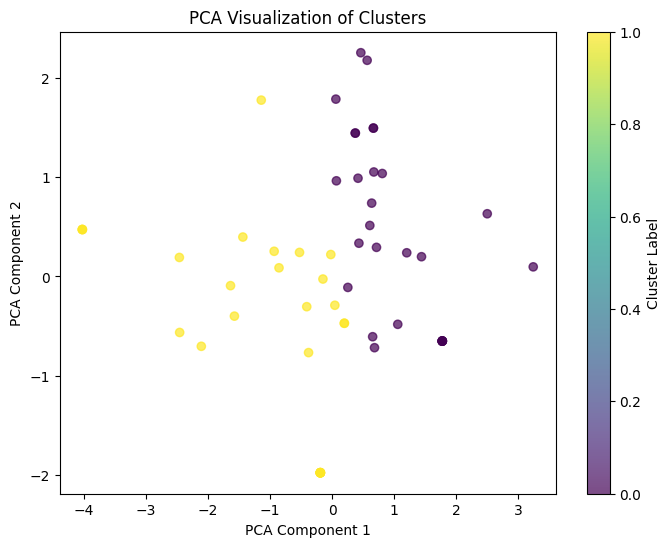

In [52]:
pca = PCA(n_components=2)
pooled_output_pca = pca.fit_transform(pooled_output_np)

# Scatter plot of clusters
plt.figure(figsize=(8,6))
plt.scatter(pooled_output_pca[:, 0], pooled_output_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Clusters")
plt.show()

In [53]:
silhouette_avg = silhouette_score(pooled_output_np, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.13702787
